# Proximidad y nuevas actividades económicas

¿Cuán importante es la proximidad geográfica y social en el desarrollo de nuevas actividades económicas?

In [321]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker, dates, cm, colors
from IPython import display
import numpy as np
import geopandas as gpd
import itertools
import textwrap
plt.style.use('publish/estilo.mplstyle')

In [360]:
def load_mapa():
    """
    Lee datos de un mapa de los límites administrativos 
    de municipios en Bolivia que puede ser descargado en
    https://archive.org/download/asfi.Servicios_Financieros_ASFI31082019/asfi:Servicios_Financieros_ASFI31082019.geojson
    
    Retorna un geodataframe con los datos necesarios
    para operaciones posteriores.
    """
    
    
    gdf = gpd.read_file('data/asfi Servicios_Financieros_ASFI31082019.geojson')
    gdf = gdf[gdf.COD_INE.notna()]
    gdf['cod_ine'] = gdf.COD_INE.astype(int)
    gdf = gdf[['cod_ine', 'DEPARTAMEN', 'MUNICIPIO', 'geometry']]
    gdf.columns = ['cod_ine', 'departamento', 'municipio', 'geometry']
    return gdf

def get_vecinos(mapa):
    """
    Consume el mapa de municipios de Bolivia y 
    retorna un diccionario donde cada llave es el 
    código INE de un municipio y su contenido 
    una lista con el código de cada municipio vecino.
    """
    
    vecinos = {}
    for index, row in mapa.iterrows():
        neighbors = mapa[mapa.geometry.touches(row['geometry'])].cod_ine.tolist() 
        vecinos[row.cod_ine] = neighbors
    return vecinos

def make_diccionario_actividades(creditos):
    """
    Construye un diccionario de cada actividad en 
    cada año para cada municipio presente en la 
    base de datos de créditos.
    """
    
    actividades = {}
    for i, a in creditos[creditos.cartera > 0].groupby(['cod_ine', 'year']).subclase:
        if i[0] not in actividades.keys():
            actividades[i[0]] = {}
        actividades[i[0]][i[1]] = a.tolist()
    return actividades
    
def make_diccionario_innovaciones(actividades_dict):
    """
    Identifica eventos donde una actividad aparece 
    por primera vez en un municipio. Retorna un diccionario 
    de estos eventos agrupados por año y municipio.
    """
    
    innovaciones = {}
    for mun in actividades_dict.keys():
        innovaciones[mun] = {}
        for year in range(2012,2020):
            if not actividades_dict[mun].__contains__(year):
                base_year = []
            else:
                prev = set([])
                [prev.update(set(actividades_dict[mun][y])) for y in actividades_dict[mun].keys() if y < year + 1]
                prev = list(prev)
            if not actividades_dict[mun].__contains__(year + 1):
                change_year = []
            else:
                change_year = actividades_dict[mun][year + 1]

            innovaciones[mun][year + 1] = list(set(change_year).difference(set(prev)))
            
    return innovaciones

def make_vecinos_influencia(innovaciones, vecinos, creditos, actividades):
    """
    Para cada evento, calcula el número de vecinos 
    que producían la misma actividad el año anterior.
    Devuelve un dataframe con información de cada evento.
    """
    
    municipios_cartera = creditos[creditos.cartera > 0].cod_ine.unique().tolist()
    influencia = []
    for mun in innovaciones.keys():
        vv = set(vecinos[mun]).intersection(set(municipios_cartera))
        if len(vv) == 0:
            for year in innovaciones[mun]:
                for actividad in innovaciones[mun][year]:
                    influencia.append({'cod_ine': mun, 'year': year, 'actividad': actividad, 'presente_vecinos': np.nan, 'presente': 0, 'vecinos': 0})
        else:
            for year in innovaciones[mun]:
                for actividad in innovaciones[mun][year]:
                    presente = 0
                    total = len(vv)
                    for v in vv:
                        if actividades[v].__contains__(year - 1):
                            if actividad in actividades[v][year - 1]:
                                presente += 1
                    influencia.append({'cod_ine': mun, 'year': year, 'actividad': actividad, 'presente_vecinos': presente/total, 'presente': presente, 'vecinos': total})
    df = pd.DataFrame(influencia)
    df['categoria'] = df.actividad.map(creditos.groupby('subclase').categoria.first().to_dict())
    return df

def influencia_por_actividad(eventos, start):
    """
    Agrupa eventos por actividad desde un año, devuelve 
    un dataframe con la media del porcentaje de vecinos 
    ue producían la actividad un año antes del evento.
    """
    
    df = eventos[eventos.year >= start]
    resumen = pd.concat(
        [
            df.groupby("actividad")[["categoria"]].first(),
            df.groupby("actividad").cod_ine.count(),
            df.groupby("actividad").presente_vecinos.mean(),
            creditos[(creditos.cartera > 0) & (creditos.year == start)].groupby('subclase').cod_ine.size()
        ],
        axis=1
    ).dropna()
    resumen.columns = ['categoria', 'eventos', 'porcentaje_vecinos', 'linea_base']
    resumen[['eventos', 'linea_base']] = resumen[['eventos', 'linea_base']].astype(int)
    return resumen

def influencia_por_categoria(influencia, min_eventos, min_actividades):
    """
    Agrupa eventos por categoría, devuelve un dataframe con
    la media y distribución estándar del porcentaje de 
    vecinos para cada actividad con al menos un número
    mínimo de eventos.
    """
    
    df = influencia[influencia.eventos >= min_eventos]
    resumen = pd.concat(
        [
            df.groupby("categoria").porcentaje_vecinos.mean(),
            df.groupby("categoria").porcentaje_vecinos.std(),
            df.groupby("categoria").eventos.count(),
        ],
        axis=1,
    )
    resumen.columns = ['porcentaje vecinos', 'desviación estándar', 'actividades']
    resumen = resumen[resumen.actividades >= min_actividades]
    return resumen[['actividades', 'porcentaje vecinos', 'desviación estándar']]

def make_migration_matrix():
    """
    Lee la matriz de flujos migratorios intermunicipales
    entre 2007 y 2012, del Censo 2012.
    """
    
    df = pd.read_csv('data/migracion_2012.csv', index_col=[0])
    municipios = pd.read_csv('data/cod_ine_censo2012.csv', names=['cod_ine', 'municipio'])
    df.index = municipios.cod_ine
    df.columns = municipios.cod_ine
    for col in df.columns:
        df[col] = pd.to_numeric(df[col].apply(lambda x: x.replace(' ', '').replace('-', ''))).fillna(0).astype(int)
    return df

def fuentes_migracion(migracion, top=10):
    """
    Devuelve una lista con un máximo de `top` municipios que envían más
    migrantes a cada municipio.
    """
    
    return {cod_ine: row[row > 0].sort_values().head(top).index.tolist() for cod_ine, row in migracion.iterrows()}

def plot_difusion(actividad, mapa, ax, since=2016):

    ax.set_axis_off()
    
    dfi = eventos[(eventos.actividad == actividad) & (eventos.year >= since)]
    mapa.plot(ax=ax, color='#e3e4e8', linewidth=.5, edgecolor='#f9f9f9')
    mapa[mapa.cod_ine.isin(creditos[(creditos.year > since) & (creditos.subclase == actividad) & (creditos.cartera > 0)].cod_ine.unique())].plot(ax=ax, color='#ced4eb', linewidth=.5, edgecolor='#f9f9f9')
    
    colormap = colors.ListedColormap(cm.get_cmap('magma')(np.linspace(.2,.8,250)))
    colores = {year: colors.to_hex(colormap((year-since)/(2021-since))) for year in range(since, 2021)}
    for year, dfyear in dfi.groupby('year'):
        mapa[mapa.cod_ine.isin(dfyear.cod_ine)].plot(ax=ax, color=colores[year], linewidth=.5, edgecolor='#f7f7f7')

In [16]:
creditos = pd.read_csv('data/creditos.csv')
mapa = load_mapa()
vecinos = get_vecinos(mapa)
inventario_actividades = make_diccionario_actividades(creditos)
innovaciones = make_diccionario_innovaciones(inventario_actividades)
eventos_frontera = make_vecinos_influencia(innovaciones, vecinos, creditos, inventario_actividades)

In [390]:
display.Markdown('Identifico eventos entre 2013 y 2020 donde se registra una actividad económica por primera vez en un municipio en la [cartera de créditos a unidades económicas](https://github.com/mauforonda/cartera_de_creditos_en_bolivia/). Para cada evento, calculo qué porcentaje de municipios fronterizos registraba la misma actividad un periodo antes. Encuentro {} eventos, por ejemplo:'.format(len(eventos_frontera)))

Identifico eventos entre 2013 y 2020 donde se registra una actividad económica por primera vez en un municipio en la [cartera de créditos a unidades económicas](https://github.com/mauforonda/cartera_de_creditos_en_bolivia/). Para cada evento, calculo qué porcentaje de municipios fronterizos registraba la misma actividad un periodo antes. Encuentro 11614 eventos, por ejemplo:

In [379]:
eventos_frontera

,cod_ine,year,actividad,presente_vecinos,presente,vecinos,categoria
0,10101,2013,fabricacion de plasticos en formas primarias y...,0.0,0,4,industria manufacturera
1,10101,2013,fabricacion de pasta de madera papel y carton,0.0,0,4,industria manufacturera
2,10101,2013,servicio de transmision de radio y television,0.0,0,4,transporte almacenamiento y comunicaciones
3,10101,2013,servicios de las cooperativas de ahorro y credito,0.0,0,4,intermediacion financiera
4,10101,2013,servicios de centros radiologicos,0.0,0,4,servicios sociales comunales y personales
...,...,...,...,...,...,...,...
11609,90203,2020,venta al por mayor de bebidas cigarrillos y t...,0.0,0,2,venta al por mayor y menor
11610,90203,2020,venta al por menor de bicicletas y rodados sim...,0.0,0,2,venta al por mayor y menor
11611,90203,2020,venta al por menor de articulos de bazar y menaje,0.5,1,2,venta al por mayor y menor
11612,90203,2020,venta al por mayor de productos farmaceuticos ...,0.0,0,2,venta al por mayor y menor


In [118]:
migracion = make_migration_matrix()
fuentes = fuentes_migracion(10)
eventos_migracion = make_vecinos_influencia(innovaciones, fuentes, creditos, inventario_actividades)

Estimo la proximidad social entre municipios mediante el flujo de migrantes que se dirige a cada municipio entre 2007 y 2012 según el Censo 2012. En cada evento, calculo qué porcentaje de los 10 municipios con más flujo migratorio exhibían la misma actividad un año antes:

In [364]:
eventos_migracion

,cod_ine,year,actividad,presente_vecinos,presente,vecinos,categoria
0,10101,2013,fabricacion de plasticos en formas primarias y...,0.000000,0,6,industria manufacturera
1,10101,2013,fabricacion de pasta de madera papel y carton,0.000000,0,6,industria manufacturera
2,10101,2013,servicio de transmision de radio y television,0.000000,0,6,transporte almacenamiento y comunicaciones
3,10101,2013,servicios de las cooperativas de ahorro y credito,0.000000,0,6,intermediacion financiera
4,10101,2013,servicios de centros radiologicos,0.000000,0,6,servicios sociales comunales y personales
...,...,...,...,...,...,...,...
11609,90203,2020,venta al por mayor de bebidas cigarrillos y t...,0.666667,4,6,venta al por mayor y menor
11610,90203,2020,venta al por menor de bicicletas y rodados sim...,0.500000,3,6,venta al por mayor y menor
11611,90203,2020,venta al por menor de articulos de bazar y menaje,0.833333,5,6,venta al por mayor y menor
11612,90203,2020,venta al por mayor de productos farmaceuticos ...,0.500000,3,6,venta al por mayor y menor


Para entender el rol de la proximidad geográfica y social sobre el desarrollo de actividades económicas, agrego eventos por actividad. Existen actividades que aparecen y desaparecen esporádicamente. Reduzco su efecto considerando sólo eventos luego de un año a mitad del periodo, en este caso 2016. Además incluyo una columna con el número de municipios que exhiben cada actividad hasta ese año para entender su ubicuidad.

In [358]:
actividades_frontera = influencia_por_actividad(eventos, start=2016)
actividades_migracion = influencia_por_actividad(eventos_migracion, start=2016)

Las 10 actividades con al menos 10 eventos y cuyo desarrollo coincide con un porcentaje mayor en municipios fronterizos un año antes son:

In [381]:
actividades_frontera[(actividades_frontera.eventos >= 10)].sort_values('porcentaje_vecinos', ascending=False).head(10)

,categoria,eventos,porcentaje_vecinos,linea_base
venta al por menor de articulos de ferreteria fontaneria y calefaccion,venta al por mayor y menor,12,0.673232,100
elaboracion de pan,industria manufacturera,15,0.606548,120
cria de ganado vacuno,agricultura y ganaderia,20,0.603070,107
fabricacion de partes y piezas de carpinteria para edificios y construcciones,industria manufacturera,13,0.586706,92
construccion reforma y reparacion de edificios,construccion,16,0.580952,126
elaboracion de otros productos de panaderia y pasteleria ncp,industria manufacturera,21,0.547262,101
servicios de expendio de bebidas alcoholicas en bares y cantinas,hoteles y restaurantes,11,0.544372,77
cria de aves,agricultura y ganaderia,16,0.542744,93
servicio de transporte automotor suburbano de pasajeros,transporte almacenamiento y comunicaciones,18,0.535574,197
venta al por menor de prendas y accesorios de vestir,venta al por mayor y menor,16,0.529497,118


Las 10 actividades con al menos 10 eventos y cuyo desarrollo coincide con un porcentaje mayor en municipios que envían más migrantes un año antes son:

In [362]:
actividades_migracion[actividades_migracion.eventos >= 10].sort_values('porcentaje_vecinos', ascending=False).head(10)

,categoria,eventos,porcentaje_vecinos,linea_base
servicio de transporte automotor de carga por carretera,transporte almacenamiento y comunicaciones,13,0.773352,116
venta al por menor en tiendas de barrio con surtido compuesto y predominio de productos alimenticios bebidas y tabaco,venta al por mayor y menor,12,0.734656,126
construccion reforma y reparacion de edificios,construccion,16,0.719147,126
servicio de transporte automotor suburbano de pasajeros,transporte almacenamiento y comunicaciones,18,0.714220,197
servicio de transporte automotor urbano de pasajeros,transporte almacenamiento y comunicaciones,11,0.712698,119
venta al por menor de carnes rojas menudencias; productos de granja y embutidos,venta al por mayor y menor,18,0.710295,113
servicios de expendio de comidas en establecimientos con servicio de mesa y/o en mostrador,hoteles y restaurantes,18,0.702337,197
elaboracion de pan,industria manufacturera,15,0.678571,120
fabricacion de prendas de vestir confeccionadas para hombres mujeres y ninos,industria manufacturera,21,0.665514,108
mantenimiento y reparacion del motor; mecanica integral,venta al por mayor y menor,16,0.658135,106


Finalmente, agrego estas actividades por categoría económica, sólo considerando casos con al menos 10 eventos y donde hay más de 1 actividad representada.

In [382]:
categorias_frontera = influencia_por_categoria(actividades_vecinos, 10, 2)
categorias_migracion = influencia_por_categoria(actividades_migracion, 10, 2)

La probabilidad de que una nueva actividad económica haya estado presente en un municipio fronterizo el año anterior es:

In [383]:
categorias_frontera.sort_values('porcentaje vecinos', ascending=False)

,actividades,porcentaje vecinos,desviación estándar
categoria,,,
hoteles y restaurantes,19,0.324482,0.114911
agricultura y ganaderia,29,0.316346,0.131006
transporte almacenamiento y comunicaciones,12,0.308649,0.145925
venta al por mayor y menor,79,0.305359,0.127822
minerales metalicos y no metalicos,3,0.299472,0.112200
servicios inmobiliarios empresariales y de alquiler,17,0.271424,0.108991
industria manufacturera,63,0.257572,0.127315
servicios sociales comunales y personales,18,0.226573,0.101256
construccion,12,0.206730,0.145570


La probabilidad de que una nueva actividad económica haya estado presente en un municipio de alta proximidad social el año anterior es:

In [126]:
categorias_migracion.sort_values('porcentaje vecinos', ascending=False)

,actividades,porcentaje vecinos,desviación estándar
categoria,,,
transporte almacenamiento y comunicaciones,12,0.372505,0.262150
venta al por mayor y menor,79,0.364534,0.183451
hoteles y restaurantes,19,0.361333,0.199257
agricultura y ganaderia,29,0.313471,0.132512
servicios inmobiliarios empresariales y de alquiler,17,0.292478,0.158437
minerales metalicos y no metalicos,3,0.285743,0.222103
industria manufacturera,63,0.235494,0.161207
construccion,12,0.221710,0.200058
servicios sociales comunales y personales,18,0.195628,0.149512


El siguiente gráfico muestra la comparación entre estas probabilidades para cada actividad y categoría económica. Considerando estas definiciones, ambas formas de proximidad están bastante correlacionadas. Sin embargo, existe suficiente heterogeneidad entre resultados para producir interpretaciones interesantes. Actividades y categorías económicas pueden diferenciarse en el tamaño del efecto que la proximidad tiene en su desarrollo y la dirección de esta proximidad. La proximidad tiene un efecto más importante en actividades de hotelería que en construcción. La proximidad geográfica es más importante en manufacturas, mientras que la proximidad social es más importante en comercio.

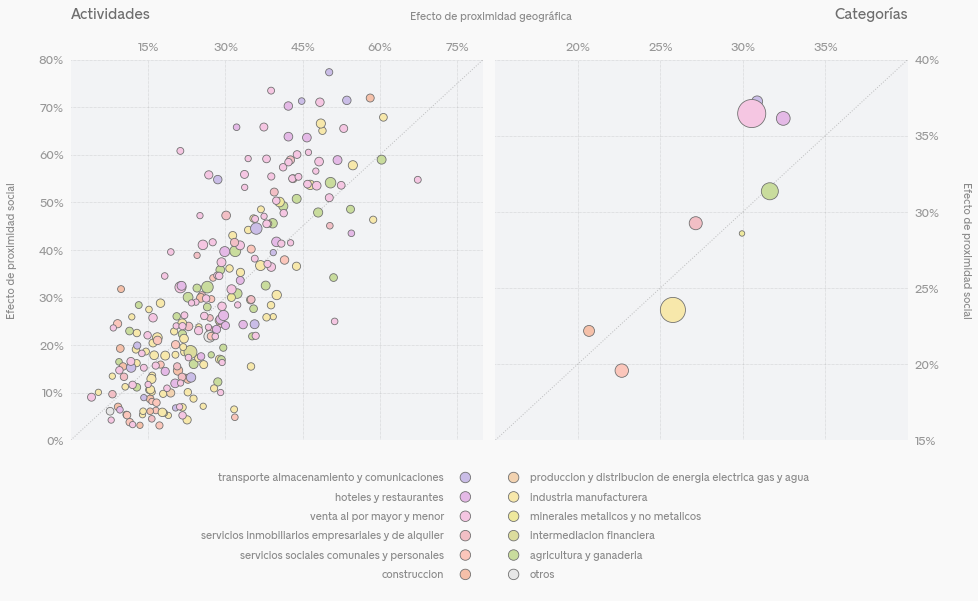

In [389]:
def plot_efecto(actividades_frontera, actividades_migracion, categorias_frontera, categorias_migracion):
    colores_categorias = {
        'venta al por mayor y menor': '#f5c6e2',
        'industria manufacturera': '#f7e8ab',
        'construccion': '#f5c0a9',
        'servicios inmobiliarios empresariales y de alquiler': '#f2bfc5',
        'transporte almacenamiento y comunicaciones': '#cabde7',
        'agricultura y ganaderia': '#c9dc9d',
        'hoteles y restaurantes': '#e4b9e6',
        'servicios sociales comunales y personales': '#fbc6bb',
        'produccion y distribucion de energia electrica gas y agua': '#f2d2b0',
        'intermediacion financiera': '#dcdc9d',
        'minerales metalicos y no metalicos': '#eee89d',
        'caza silvicultura y pesca': '#e7e7e7',
        'educacion': '#e7e7e7',
        'servicio de hogares privados que contratan servicio domestico': '#e7e7e7',
        'actividades atipicas': '#e7e7e7',
        'administracion publica defensa y seguridad social obligatoria': '#e7e7e7',
        'extraccion de petroleo crudo y gas natural': '#e7e7e7',
        'servicio de organizaciones y organos extraterritoriales': '#e7e7e7',
        'otros': '#e7e7e7',
    }
    categorias_orden = [
        'transporte almacenamiento y comunicaciones',
        'hoteles y restaurantes',
        'venta al por mayor y menor',
        'servicios inmobiliarios empresariales y de alquiler',
        'servicios sociales comunales y personales',
        'construccion',
        'produccion y distribucion de energia electrica gas y agua',
        'industria manufacturera',
        'minerales metalicos y no metalicos',
        'intermediacion financiera',
        'agricultura y ganaderia',
        'otros'
    ]
    
    linecolor = '#6e6e6e'
    
    actividades_efecto = pd.concat([actividades_frontera[['categoria', 'eventos', 'porcentaje_vecinos']], actividades_migracion.porcentaje_vecinos], axis=1)
    actividades_efecto.columns = ['categoria', 'eventos', 'porcentaje_vecinos_territorio', 'porcentaje_vecinos_migracion']
    actividades_efecto['color'] = actividades_efecto.categoria.map(colores_categorias)
    actividades_efecto = actividades_efecto[actividades_efecto.eventos >= 10]
    
    categorias_efecto = pd.concat([categorias_frontera[['actividades', 'porcentaje vecinos']], categorias_migracion['porcentaje vecinos']], axis=1)
    categorias_efecto.columns = ['eventos', 'porcentaje_vecinos_territorio', 'porcentaje_vecinos_migracion']
    categorias_efecto['color'] = categorias_efecto.index.map(colores_categorias)

    f, axs = plt.subplots(1,2,figsize=(15,7))
    plt.subplots_adjust(wspace=.03)
    
    for ax, dfi, limits, scale, right_ticks in zip(axs, [actividades_efecto, categorias_efecto], [[.0, .8], [.15, .4]], [4, 10], [False, True]):
        ax.scatter(dfi.porcentaje_vecinos_territorio, dfi.porcentaje_vecinos_migracion, s=dfi.eventos * scale, c=dfi.color, linewidth=.8, edgecolor=linecolor, alpha=1., zorder=2)
        ax.grid()
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(ticker.PercentFormatter(1,0))
        ax.xaxis.set_major_locator(ticker.MaxNLocator(6, prune='both'))
        ax.set_xlim(limits)
        ax.set_ylim(limits)
        ax.tick_params(labelcolor=linecolor, labeltop=True, labelbottom=False)
        if right_ticks:
            ax.tick_params(labelleft=False, labelright=True)
        for label in list(itertools.chain.from_iterable([ax.get_xticklabels(), ax.get_yticklabels()])):
            label.set_alpha(.7)
        ax.plot(limits, limits, linewidth=1, color=linecolor, alpha=.4, linestyle=':', zorder=1)
    axs[0].annotate('Efecto de proximidad geográfica', xy=(1.02,1.1), xycoords='axes fraction', fontsize=11, alpha=.8, color=linecolor, ha='center', va='bottom')
    axs[0].annotate('Efecto de proximidad social', xy=(-.13, .5), xycoords='axes fraction', fontsize=11, alpha=.8, color=linecolor, ha='right', va='center', rotation=90)
    axs[1].annotate('Efecto de proximidad social', xy=(1.13, .5), xycoords='axes fraction', fontsize=11, alpha=.8, color=linecolor, ha='left', va='center', rotation=270)
    
    axs[0].annotate('Actividades', xy=(.0,1.1), xycoords='axes fraction', fontsize=15, alpha=1., color=linecolor, ha='left', va='bottom')
    axs[1].annotate('Categorías', xy=(1.,1.1), xycoords='axes fraction', fontsize=15, alpha=1., color=linecolor, ha='right', va='bottom')
            
    for categorias_section, esquina, x, ha, xlim  in zip([categorias_orden[:6], categorias_orden[6:]], [.457, .46], [.4, 1.6], ['right', 'left'], [(0,3), (-2,2)]):
        cax = f.add_axes([esquina, -.18, .1, .25])
        cax.scatter(x=len(categorias_section) * [1], y=range(len(categorias_section)),  color=[colores_categorias[categoria] for categoria in categorias_section], s=110, linewidth=.8, edgecolor=linecolor)
        cax.set_xlim(xlim)
        cax.set_ylim(6.,-.5)
        for categoria, position in zip(categorias_section, range(len(categorias_section))):
            cax.annotate('\n'.join(textwrap.wrap(categoria, 100)), xy=(x, position), xycoords='data', ha=ha, va='center', fontsize=11, color=linecolor, alpha=.8)
        cax.set_axis_off()

plot_efecto(actividades_frontera, actividades_migracion, categorias_frontera, categorias_migracion)